<a href="https://colab.research.google.com/github/giramos/Machine-Learning/blob/master/Sesion02.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Aprendizaje automático 2
## 1 Esquemas de validación
Hasta ahora siempre hemos tenido un conjunto de datos para entrenar y otro para validar. Sin embargo, esto no es común en la realidad. Lo habitual es disponer de un único dataset etiquetado y no disponer de nuevos datos etiquetados después. En estos casos, es necesario usar el conjunto de datos etiquetados tanto para entrenar y validar el modelo. En esta sección veremos dos técnicas para realizar el entrenamiento y evaluación del modelo sobre un único dataset: **Hold-out y K-Fold Cross Validation (Validación cruzada).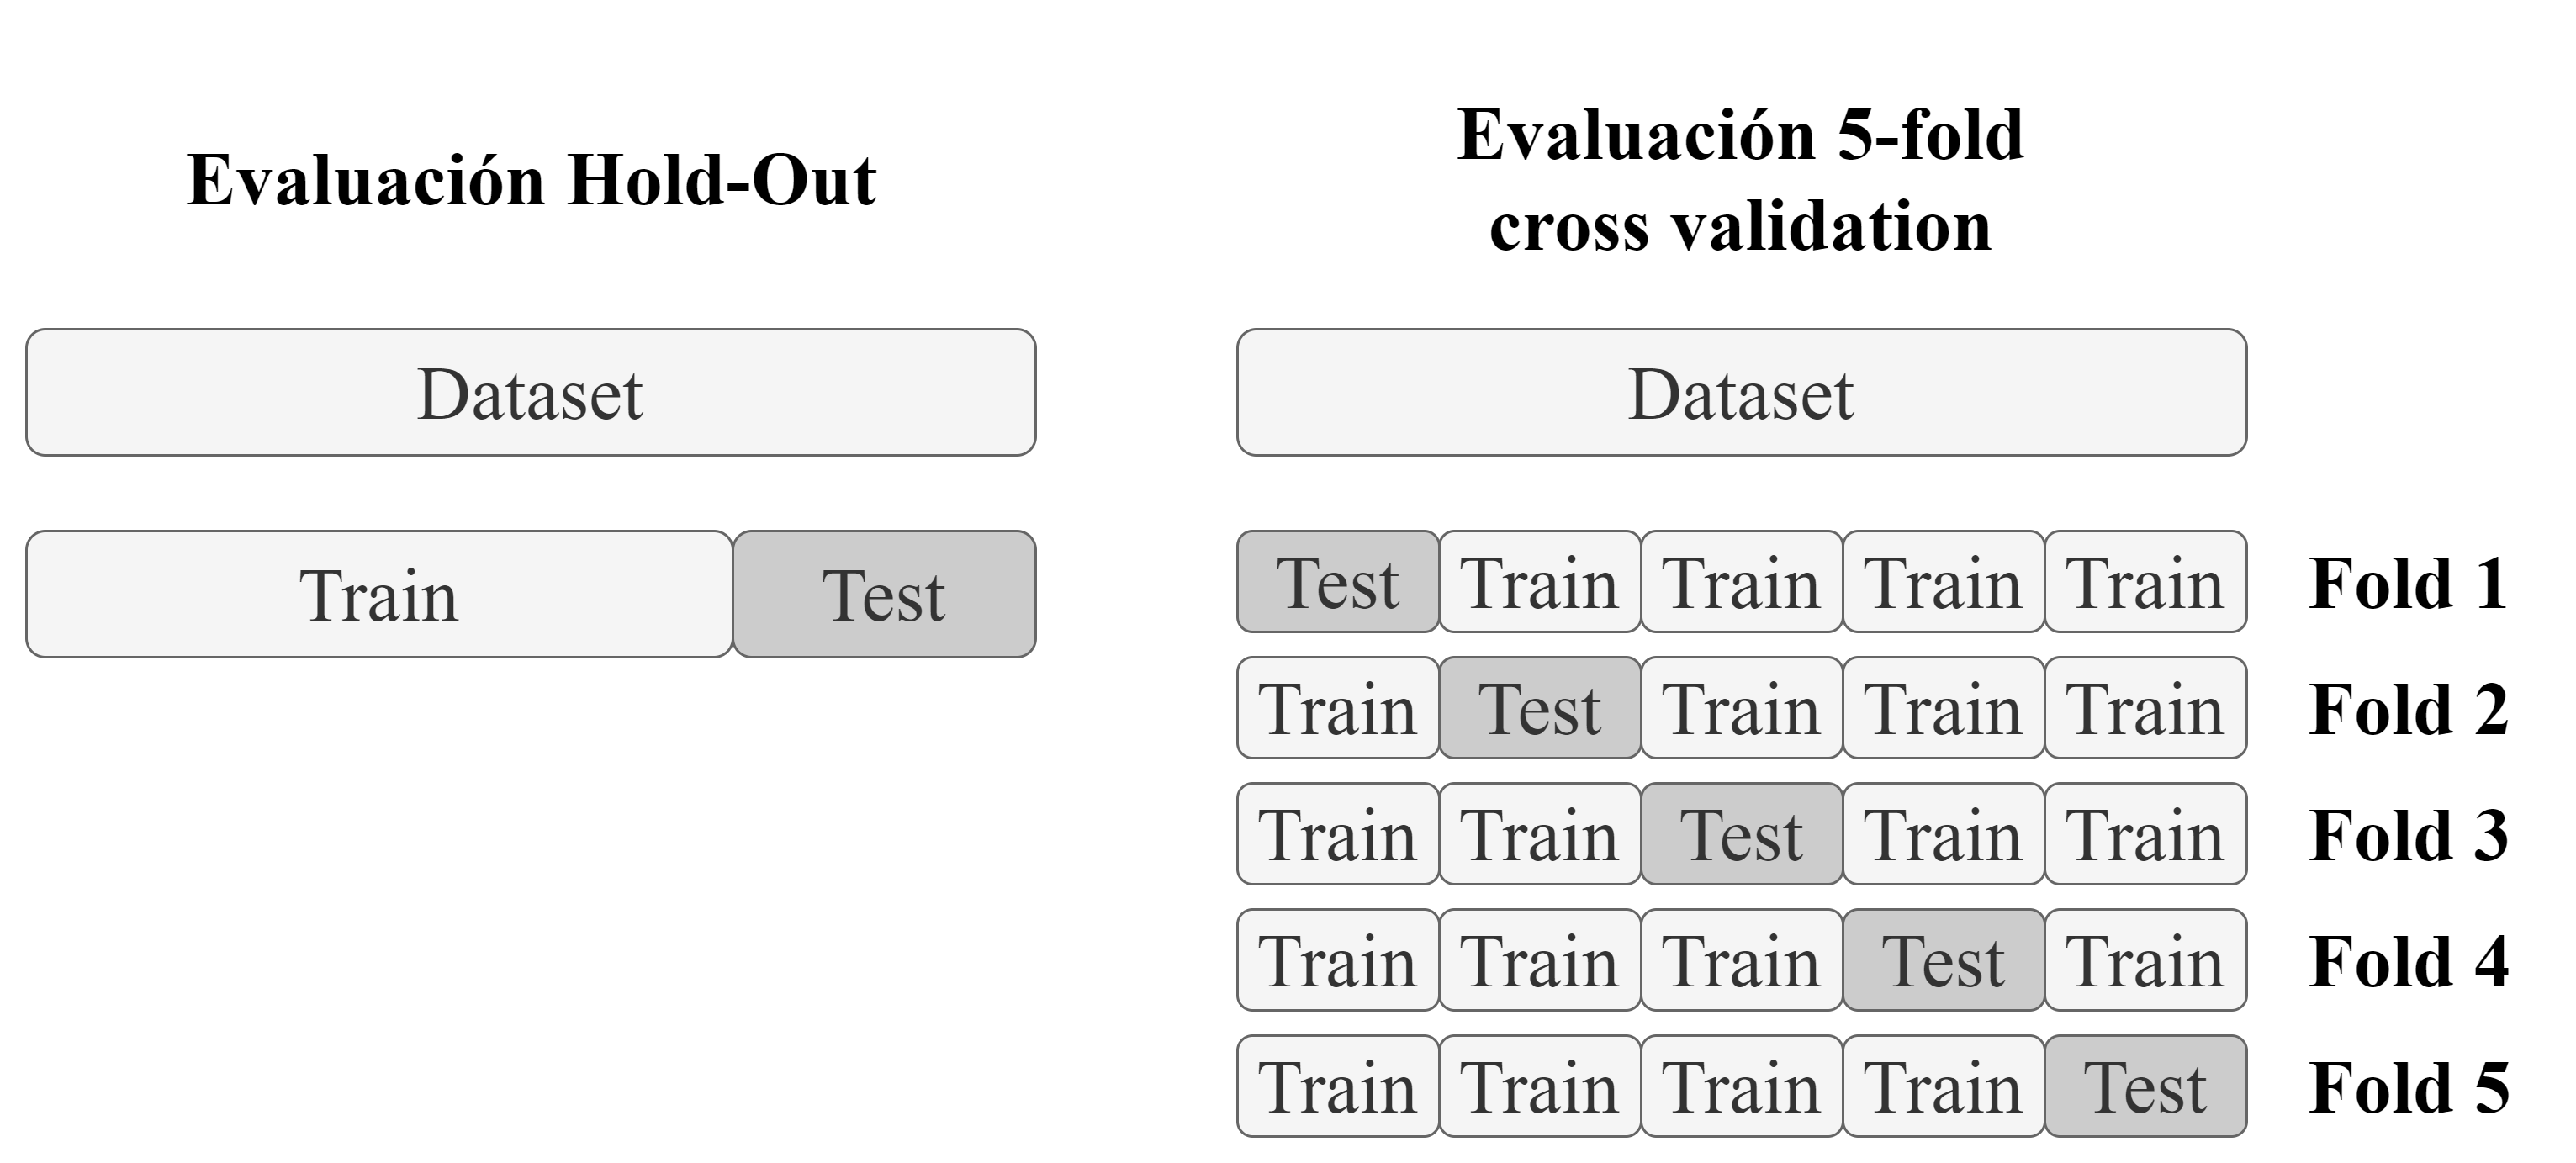**

Ambos métodos consisten básicamente en dividir el conjunto de datos en particiones para entrenamiento y validación (ver Figure 1):

Las particiones de entrenamiento se utilizan como conjunto de entrenamiento: para comprobar que métodos de preprocesamiento debemos aplicar, para determinar qué modelo debemos usar y para entrenar el modelo.
Las particiones de validación se utilizan como conjunto de test: para evaluar el rendimiento del modelo.

Sobre las particiones del dataset
Las particiones de datos deben ser aleatorias, pero debemos tener cuidado:

En algunos problemas, el resultado puede variar mucho dependiendo de la partición de test que hagamos.
Al ser aleatoria, puede ocurrir que las particiones tengan diferente porcentaje de instancias de cada clase.
Para lo segundo, veremos que lo mejor es utilizar estratificación: dividir el dataset de forma aleatoria, pero manteniendo siempre el mismo porcentaje de instancias de cada clase. Por ejemplo, si el dataset original tenía un 60% de instancias de personas con alta actividad y un 40% de personas con baja intensidad, las particiones estratificadas también tendrán un 60% y un 40% respectivamente.

Vamos a ver un ejemplo de ambos, para lo cual volvemos a cargar los datos de datos05_train.csv y creamos un pipeline para un modelo
-NN con
 vecinos. Primero cargamos los datos como siempre:

In [ ]:
import pandas as pd

# Cargar el conjunto de datos
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/datasets/datos05_train.csv")

# Separar las variables (X) de las etiquetas (y)
X_train = df.drop(columns=["ActividadFisica"]) # Quitar la columna de clase
y_train = df["ActividadFisica"]

Comprobar el número de instancias y si existen valores faltantes:

In [ ]:
print(f"Nº de instancias {len(X_train)}\n")
X_train.info()

Nº de instancias 1500

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Peso              1480 non-null   float64
 1   Estatura          1484 non-null   float64
 2   Edad              1484 non-null   float64
 3   PctGrasaCorporal  1491 non-null   float64
 4   EstadoCivil       1486 non-null   object 
dtypes: float64(4), object(1)
memory usage: 58.7+ KB


Comprobar el rango de valores de las variables numéricas:

In [ ]:
X_train.describe()

,Peso,Estatura,Edad,PctGrasaCorporal
count,1480.000000,1484.000000,1484.000000,1491.000000
mean,73.341659,168.992790,46.064016,16.425865
std,21.757760,11.276414,16.566524,7.176750
min,40.000000,139.300000,18.000000,5.000000
25%,61.175000,160.900000,32.000000,13.100000
50%,71.400000,168.500000,45.000000,15.900000
75%,81.600000,176.550000,60.250000,18.800000
max,298.361170,201.300000,74.000000,98.042779


Ahora creamos el pipeline:

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.neighbors import KNeighborsClassifier

# Cargar el conjunto de datos
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/datasets/datos05_train.csv")

# Separar las variables (X) de las etiquetas (y)
X_orig = df.drop(columns=["ActividadFisica"]) # Quitar la columna de clase
y_orig = df["ActividadFisica"]

categorical_features = X_orig.select_dtypes(include=["object"]).columns.tolist() # Variables categóricas
numeric_features = X_orig.select_dtypes(include=["number"]).columns.tolist() # Variables numéricas

# Primer pipeline: preprocesar las variables numéricas
numeric_transformer = Pipeline(steps=[("imputer", SimpleImputer(strategy="mean")), ("scaler", StandardScaler())])

# Segundo pipeline: preprocesar las variables categóricas
categorical_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="most_frequent")), ("encoder", OneHotEncoder(handle_unknown="ignore"))]
)

# Create a pipeline de preprocesamiento
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)

model = KNeighborsClassifier(n_neighbors=3)

# Crear el pipeline final
pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor), # Primer paso: preprocesador los datos
    ("classifier", model)           # Segundo paso: clasificar los datos
])

pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Peso', 'Estatura', 'Edad',
                                                   'PctGrasaCorporal']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['EstadoCivil'])])),
                ('classifier', KNeighborsClassifier(n_neighbors=3))])

### 1.1 Hold-out
En el método **Hold-out** se divide el conjunto de datos en solo dos partes: una para entrenar y otra para validar (ver Figure 2). Típicamente, se utiliza un
 de los datos para entrenamiento y un
 para test, aunque cuando disponemos de pocos datos también es usual rebajar el tamaño del conjunto de test: 80
 entrenamiento - 20
 test.
 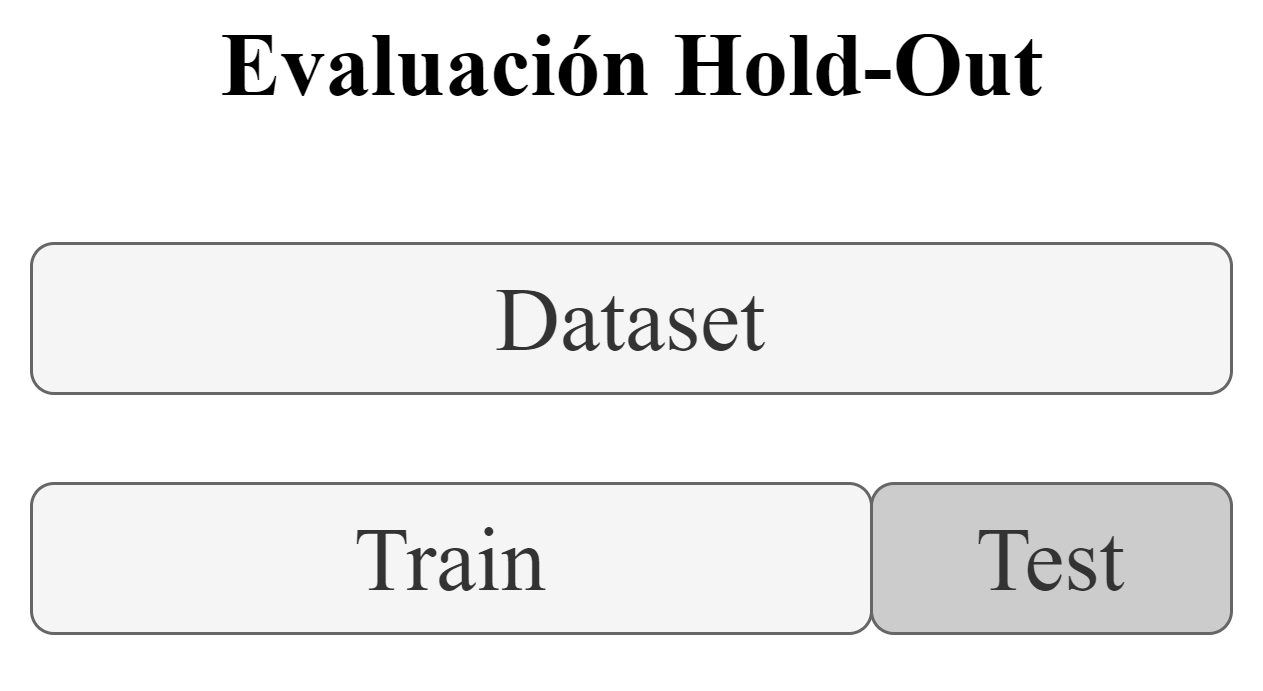
 En sklearn se puede hacer con la función train_test_split del módulo sklearn.model_selection.

In [ ]:
from sklearn.model_selection import train_test_split

# Dividir el dataset en entrenamiento y test
# random_state fija la semilla aleatoria para que los resultados sean reproducibles
# stratify mantiene el porcentaje de instancias de cada clase
X_train, X_test, y_train, y_test = train_test_split(X_orig, y_orig, test_size=0.25, random_state=348, stratify=y_orig)

print(f"Nº de instancias de entrenamiento: {len(X_train)}")
print(f"Nº de instancias de test: {len(X_test)}")

Nº de instancias de entrenamiento: 1125
Nº de instancias de test: 375


Y ahora entrenamos el modelo sobre la partición de entrenamiento y lo evaluamos sobre la partición de test:

In [ ]:
from sklearn.metrics import accuracy_score

# Entrenar con los datos de entrenamiento
pipeline.fit(X_train, y_train)

# Predecir las etiquetas de los datos de test
y_pred = pipeline.predict(X_test)

# Obtener el accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.3f}")

Accuracy: 0.917


El problema de esta técnica es que es dependiente de la partición que se haya originado: si cambiamos la semilla aleatoria, pueden llegar a obtener resultados notablemente diferentes.

In [ ]:
# Dividir el dataset en entrenamiento y test con una semilla diferente
X_train, X_test, y_train, y_test = train_test_split(X_orig, y_orig, test_size=0.25, random_state=381, stratify=y_orig)

pipeline.fit(X_train, y_train) # Entrenar

y_pred = pipeline.predict(X_test) # Predecir

accuracy = accuracy_score(y_test, y_pred) # Obtener el accuracy
print(f"Accuracy: {accuracy:.3f}")

Accuracy: 0.976


De aquí la motivación de utilizar **K-Fold Cross Validation.**

### 1.2 K-Fold Cross Validation
En la técnica de **K-Fold Cross Validation** (K-Fold CV) se divide el conjunto de datos en
 particiones (folds) de igual tamaño (ver el ejemplo de 5-fold CV de Figure 3). La idea detrás de CV es evitar la dependencia de la partición entrenamiento-test que vimos en Hold-Out.

El proceso de entrenamiento-predicción se realiza
 veces: cada vez se utiliza una partición distinta como conjunto de test y el resto se juntan como conjunto de entrenamiento. Las métricas de error finales son el promedio de los resultados obtenidos en cada fold. Típicamente se utiliza
, aunque si el método es computacionalmente costoso también se puede utilizar
 o incluso
. Cuanto menor sea
, peor estimación del rendimiento obtendremos a nivel estadístico.
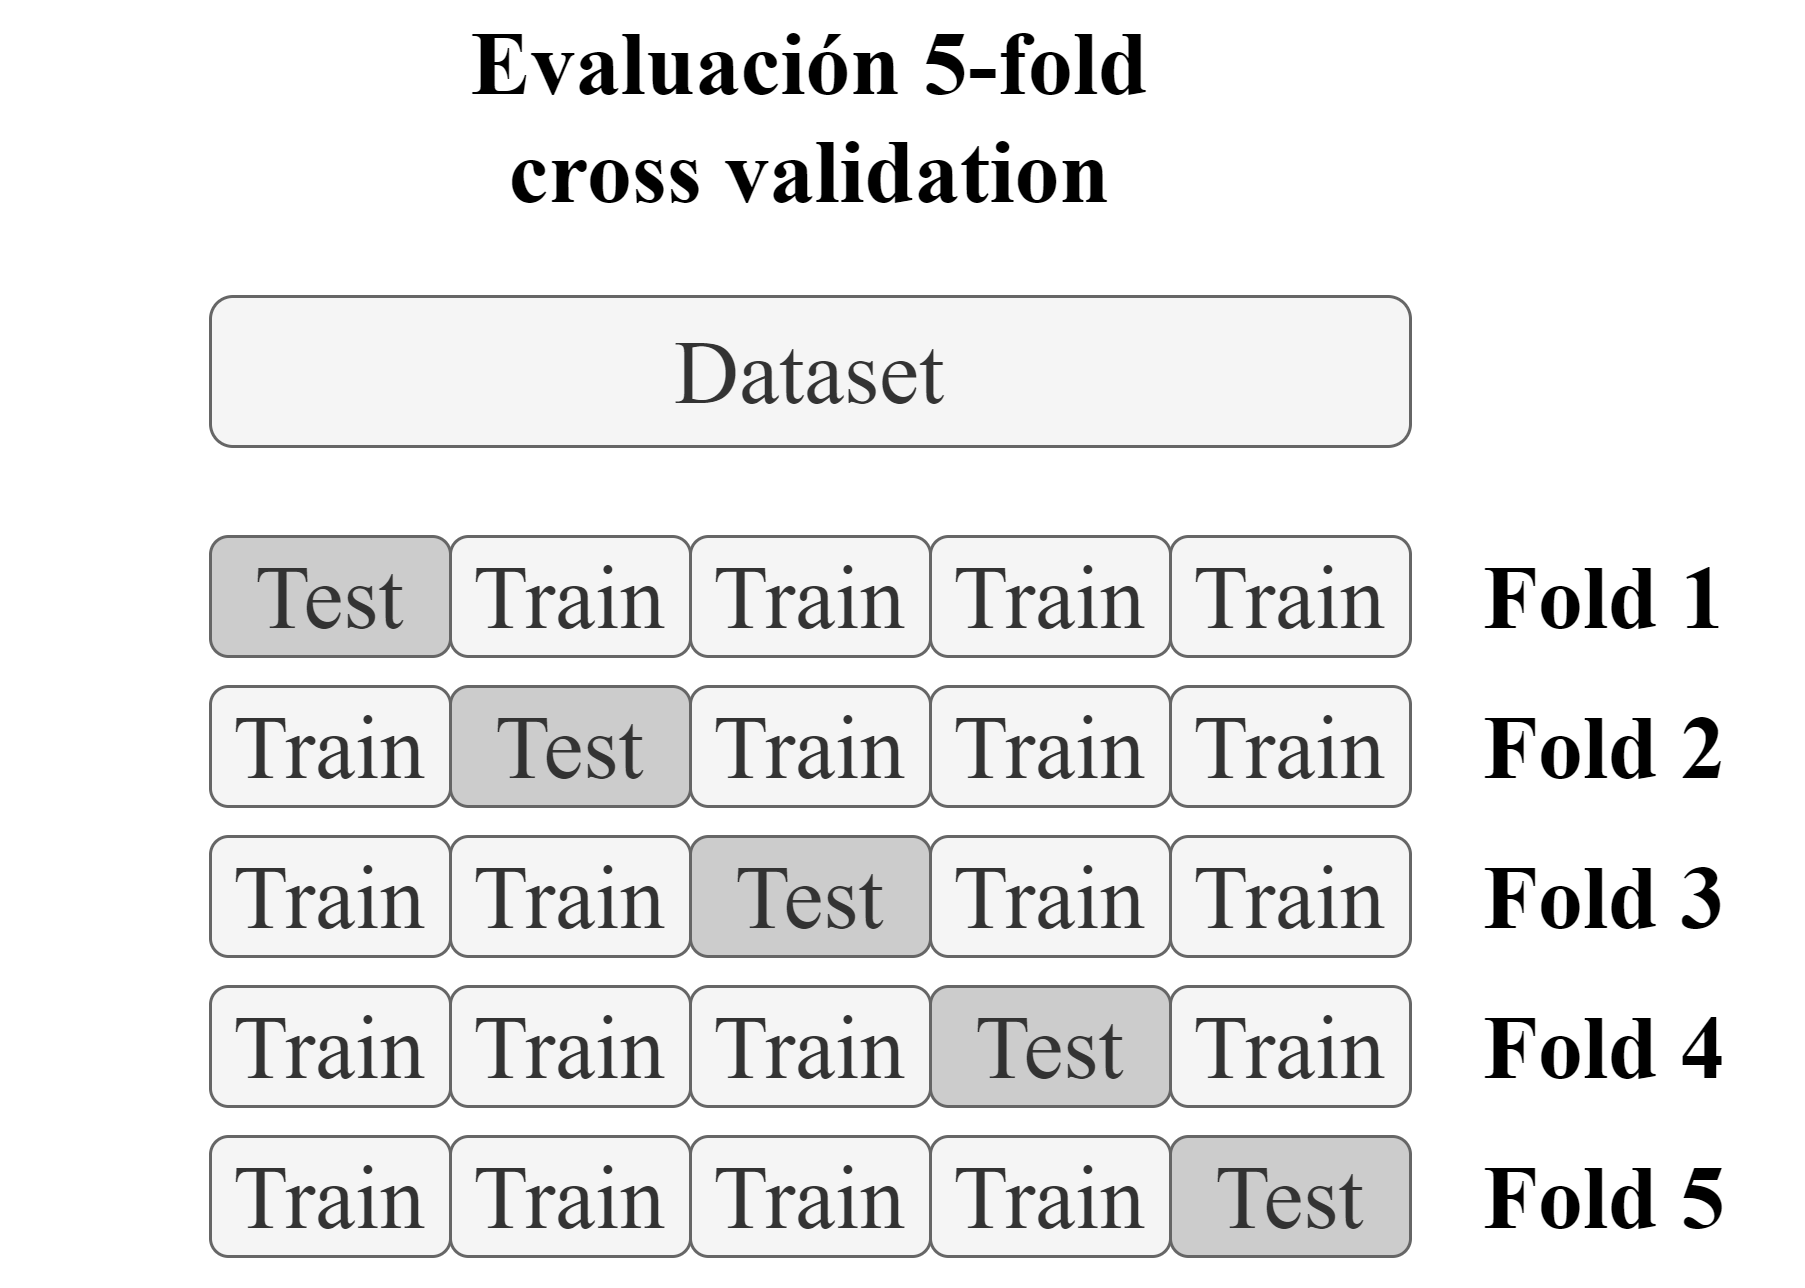

Figure 3: Evaluación mediante 5-fold Cross Valdidation.
En sklearn se puede hacer con la función cross_val_score del módulo sklearn.model_selection.

In [ ]:
from sklearn.model_selection import cross_val_score

# Realizar 10-fold cross validation
scores = cross_val_score(pipeline, X_orig, y_orig, cv=10) # Por defecto va a estratificar las particiones

print(f"Accuracy values: {[round(i, 3) for i in scores]}")
print(f"Accuracy media +- std: {scores.mean():.3f} (+/- {scores.std() * 2:.3f})")

Accuracy values: [0.96, 0.973, 0.967, 0.947, 0.947, 0.947, 0.94, 0.967, 0.947, 0.967]
Accuracy media +- std: 0.956 (+/- 0.022)


En este caso, el resultado es el promedio de los resultados obtenidos en cada fold. La desviación estándar nos da una idea de la variabilidad de los resultados obtenidos. skelearn ofrece diferentes estrategias para dividir el dataset: por ejemplo, si queremos mezclar aleatoriamente los datos antes de hacer las particiones, podemos declarar nuestro objeto de partición de la siguiente forma:

In [ ]:
from sklearn.model_selection import StratifiedKFold

cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=27) # Así podemos reordenar aleatoriamente los datos antes de empezar CV

scores = cross_val_score(pipeline, X_orig, y_orig, cv=cv)

print(f"Accuracy values: {[round(i, 3) for i in scores]}")
print(f"Accuracy media +- std: {scores.mean():.3f} (+/- {scores.std() * 2:.3f})")

Accuracy values: [0.967, 0.96, 0.947, 0.94, 0.96, 0.947, 0.933, 0.967, 0.947, 0.953]
Accuracy media +- std: 0.952 (+/- 0.021)


Lo interesante de CV es que, aunque cambiemos la semilla aleatoria, los resultados obtenidos variarán mucho menos:

In [ ]:
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=43)

scores = cross_val_score(pipeline, X_orig, y_orig, cv=cv)

print(f"Accuracy values: {[round(i, 3) for i in scores]}")
print(f"Accuracy media +- std: {scores.mean():.3f} (+/- {scores.std() * 2:.3f})")

Accuracy values: [0.947, 0.973, 0.947, 0.98, 0.993, 0.96, 0.96, 0.967, 0.953, 0.94]
Accuracy media +- std: 0.962 (+/- 0.032)


Además, si utilizamos la función cross_validate junto con el parámetro return_train_score=True para realizar la CV, podemos acceder a las métricas individuales en entrenamiento, a los tiempos de ejecución, etc.:

In [ ]:
from sklearn.model_selection import cross_validate

cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=0)

scores = cross_validate(pipeline, X_orig, y_orig, cv=cv, return_train_score=True)

print(f"Tiempo de train: {scores['fit_time'].mean():.3f} segundos")
print(f"Tiempo de test: {scores['score_time'].mean():.3f} segundos")

print(f"\nAccuracy en train: {scores['train_score'].mean():.3f} +- {scores['train_score'].std():.3f}")
print(f"Accuracy en test: {scores['test_score'].mean():.3f} +- {scores['test_score'].std():.3f}")

Tiempo de train: 0.014 segundos
Tiempo de test: 0.015 segundos

Accuracy en train: 0.977 +- 0.001
Accuracy en test: 0.958 +- 0.014


Existen otras técnicas de CV, por ejemplo:

Leave-One-Out (LOO) CV, donde cada punto se utiliza como test exactamente una vez y el modelo se entrena con los datos restantes.
Realizar varias repeticiones de la CV utilizando la clase ReapetedKFold.
etc.
Cualquiera de ellas funciona de la misma forma que la validación cruzada que hemos visto: se instancia un objeto que se pasa como parámetro cv a la función cross_val_score o cross_validate. Puedes consultar todas las técnicas de validación disponibles en la documentación.

DOCUMENTACION: sklearn.model_selection
Tools for model selection, such as cross validation and hyper-parameter tuning.

User guide. See the Cross-validation: evaluating estimator performance, Tuning the hyper-parameters of an estimator, and Learning curve sections for further details.

Splitters
GroupKFold

K-fold iterator variant with non-overlapping groups.

GroupShuffleSplit

Shuffle-Group(s)-Out cross-validation iterator.

KFold

K-Fold cross-validator.

LeaveOneGroupOut

Leave One Group Out cross-validator.

LeaveOneOut

Leave-One-Out cross-validator.

LeavePGroupsOut

Leave P Group(s) Out cross-validator.

LeavePOut

Leave-P-Out cross-validator.

PredefinedSplit

Predefined split cross-validator.

RepeatedKFold

Repeated K-Fold cross validator.

RepeatedStratifiedKFold

Repeated Stratified K-Fold cross validator.

ShuffleSplit

Random permutation cross-validator.

StratifiedGroupKFold

Stratified K-Fold iterator variant with non-overlapping groups.

StratifiedKFold

Stratified K-Fold cross-validator.

StratifiedShuffleSplit

Stratified ShuffleSplit cross-validator.

TimeSeriesSplit

Time Series cross-validator.

check_cv

Input checker utility for building a cross-validator.

train_test_split

Split arrays or matrices into random train and test subsets.

Hyper-parameter optimizers
GridSearchCV

Exhaustive search over specified parameter values for an estimator.

HalvingGridSearchCV

Search over specified parameter values with successive halving.

HalvingRandomSearchCV

Randomized search on hyper parameters.

ParameterGrid

Grid of parameters with a discrete number of values for each.

ParameterSampler

Generator on parameters sampled from given distributions.

RandomizedSearchCV

Randomized search on hyper parameters.

Post-fit model tuning
FixedThresholdClassifier

Binary classifier that manually sets the decision threshold.

TunedThresholdClassifierCV

Classifier that post-tunes the decision threshold using cross-validation.

Model validation
cross_val_predict

Generate cross-validated estimates for each input data point.

cross_val_score

Evaluate a score by cross-validation.

cross_validate

Evaluate metric(s) by cross-validation and also record fit/score times.

learning_curve

Learning curve.

permutation_test_score

Evaluate the significance of a cross-validated score with permutations.

validation_curve

Validation curve.

Visualization
LearningCurveDisplay

Learning Curve visualization.

ValidationCurveDisplay

Validation Curve visualization.

**EJERCICIO**: evaluación de un modelo
k-NN (15 minutos)

Siguiendo con el dataset MathLearningDataset.csv, aplica el preprocesamiento que diseñamos anteriormente y evalúa un modelo
k-NN mediante:

Hold-Out con 25% de datos para test.
Validación cruzada con 10 folds.

**1. Carga y preprocesamiento de** **datos**

In [94]:
import pandas as pd
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

# Carga del dataset
data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/datasets/MathLearningDataset.csv')

data.info()

# a. Eliminación de columnas irrelevantes
data = data.drop(['Student ID', 'Question ID'], axis=1)

# b. Manejo de valores nulos (imputación con la media/moda)
numeric_features = ['Student Age', 'Response Time (s)']
categorical_features = ['Student Country', 'Question Level', 'Topic', 'Subtopic']

numeric_imputer = SimpleImputer(strategy='mean')
categorical_imputer = SimpleImputer(strategy='most_frequent')

data[numeric_features] = numeric_imputer.fit_transform(data[numeric_features])
data[categorical_features] = categorical_imputer.fit_transform(data[categorical_features])

# c. Codificación de variables categóricas y estandarización de numéricas
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)])

# d. Separación de características y etiquetas
X = data.drop('Type of Answer', axis=1)
y = data['Type of Answer']

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9546 entries, 0 to 9545
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Student ID         9546 non-null   int64  
 1   Student Country    9463 non-null   object 
 2   Question ID        9546 non-null   int64  
 3   Type of Answer     9546 non-null   int64  
 4   Question Level     9461 non-null   object 
 5   Topic              9473 non-null   object 
 6   Subtopic           9474 non-null   object 
 7   Student Age        9460 non-null   float64
 8   Response Time (s)  9468 non-null   float64
dtypes: float64(2), int64(3), object(4)
memory usage: 671.3+ KB


**2. Hold-Out**

In [95]:
# 2. Hold-Out
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Pipeline para preprocesamiento y modelo
pipeline = Pipeline([('preprocessor', preprocessor), ('knn', KNeighborsClassifier(n_neighbors=5))])

# Entrenamiento y evaluación del modelo
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f'Precisión Hold-Out: {accuracy}')

Precisión Hold-Out: 0.5798072894847088


**3. Validación cruzada con 10 folds**


In [96]:
# 3. Validación cruzada con 10 folds
kf = KFold(n_splits=10, shuffle=True, random_state=42)
accuracies = []

for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Entrenamiento y evaluación del modelo (con pipeline)
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    accuracies.append(accuracy)

avg_accuracy = sum(accuracies) / len(accuracies)
print(f'Precisión promedio K-Fold: {avg_accuracy}')

Precisión promedio K-Fold: 0.5930205143402812


## 2 Recordando las métricas de evaluación

Hasta ahora hemos utilizado el accuracy como métrica de evaluación. Sin embargo, dependiendo del problema, el accuracy puede no ser la mejor métrica. Por ejemplo, en problemas desbalanceados, donde una clase tiene muchas más instancias que otra, el accuracy puede ser engañoso. Imagina un problema donde la clase positiva tiene un
 de instancias y la clase negativa un
. Un modelo que siempre prediga la clase positiva tendría un accuracy del
, pero no sería un buen modelo. Conviene fijarse en otras métricas para comprender correctamente cómo está funcionando el modelo.

En sklearn podemos obtener muchas métricas de evaluación. Por ejemplo, para un modelo de clasificación, podemos obtener la matriz de confusión, la precisión, la sensibilidad, la especificidad, el F1-score, etc. Veamos un ejemplo con el dataset MathLearningDataset.csv:

prueba


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns


# Dividir el dataset en entrenamiento y test con una semilla diferente
X_train, X_test, y_train, y_test = train_test_split(
    X_orig, y_orig, test_size=0.25, shuffle=True, random_state=381, stratify=y_orig
)

pipeline.fit(X_train, y_train)  # Entrenar

y_pred = pipeline.predict(X_test)  # Predecir

# Visualizamos la matriz de confusión
cm = confusion_matrix(y_test, y_pred)

target_names = ["Respuesta incorrecta", "Respuesta correcta"]

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Reds", xticklabels=target_names, yticklabels=target_names)
plt.xlabel("Etiquetas predichas")
plt.ylabel("Etiquetas real")
plt.title("Matriz de confusión")
plt.show()

Y también la podemos visualizar normalizada por cada clase:

In [57]:
cm_norm = cm / cm.sum(axis=0)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_norm, fmt=".2f", annot=True, cmap="Reds", xticklabels=target_names, yticklabels=target_names)
plt.xlabel("Etiquetas predichas")
plt.ylabel("Etiquetas real")
plt.title("Matriz de confusión normalizada")
plt.show()

NameError: name 'cm' is not defined

Y podemos ver otras métricas de evaluación con classification_report:

In [ ]:
class_report = pd.DataFrame(classification_report(y_test, y_pred, target_names=target_names, output_dict=True))

print("Métricas de evaluación por clases:")
display(class_report.T.iloc[:2, :])

print("\nMétricas de evaluación medias:\n")
print(class_report.iloc[0, 2:].rename("métricas medias").to_string(index=True))

Métricas de evaluación por clases

precision	recall	f1-score	support
Respuesta incorrecta	0.606682	0.629630	0.617943	1269.0
Respuesta correcta	0.560748	0.536673	0.548446	1118.0

Métricas de evaluación medias:

accuracy        0.586091
macro avg       0.583715
weighted avg    0.585168

## 3 Optimización de hiperparámetros
Lo habitual es probar el modelo con diferentes configuraciones de sus hiperparámetros. Por ejemplo, en el caso de KNN, ¿para qué número de vecinos de funciona mejor?

Esta búsqueda está automatizada con GridSearchCV en scikit-learn, donde se utiliza la CV para determinar la mejor combinación de hiperparámetros para entrenar el modelo. Como los conjuntos de validación durante la CV se utilizarán para tomar decisiones sobre el modelo, corremos el riesgo de que exista data leaking.

Por este motivo es habitual generar una partición inicial en entrenamiento y test (como en Hold-Out), realizar la CV sobre la partición de entrenamiento y evaluar finalmente el modelo óptimo en la de test (ver el ejemplo de grid search con 5-fold CV de Figure 4). A esta estructura se la llama train-validation-test y asegura que el modelo se valida en datos nunca utilizados.
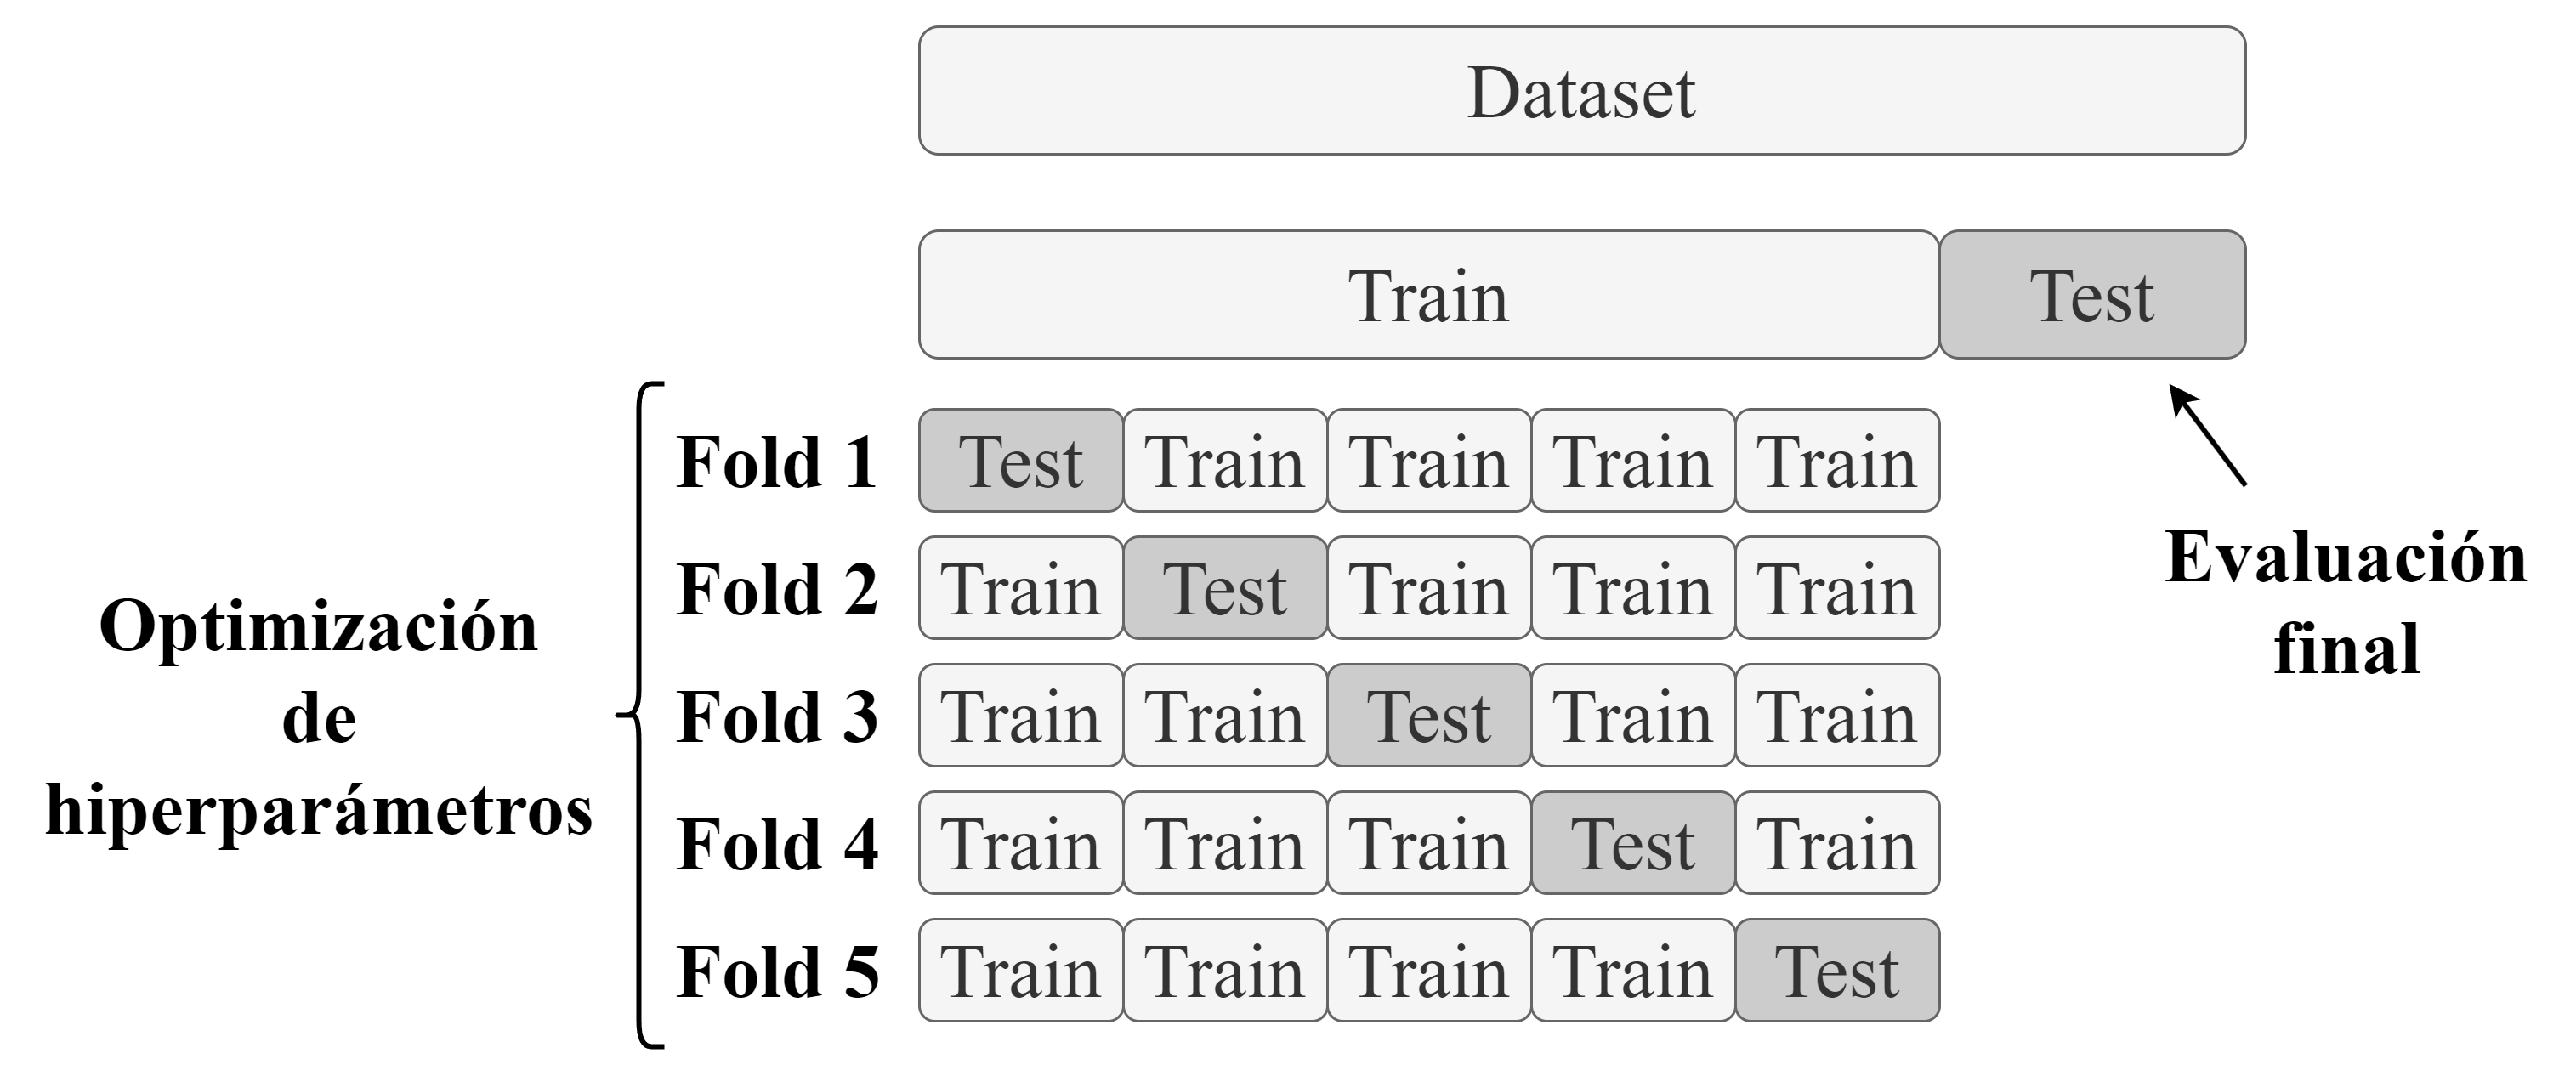
Figure 4: Grid search mediante 5-fold Cross Valdidation, con evaluación final en Hold-Out.
Vamos a ver un ejemplo con el dataset anterior (datos05_train.csv), utilizando un pipeline para un modelo
k-NN y buscando optimizar el número de vecinos. La creación del pipeline es igual que antes:


In [58]:
# Cargar el conjunto de datos
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/datasets/datos05_train.csv")

# Separar las variables (X) de las etiquetas (y)
X_orig = df.drop(columns=["ActividadFisica"]) # Quitar la columna de clase
y_orig = df["ActividadFisica"]

categorical_features = X_orig.select_dtypes(include=["object"]).columns.tolist() # Variables categóricas
numeric_features = X_orig.select_dtypes(include=["number"]).columns.tolist() # Variables numéricas

# Primer pipeline: preprocesar las variables numéricas
numeric_transformer = Pipeline(steps=[("imputer", SimpleImputer(strategy="mean")), ("scaler", StandardScaler())])

# Segundo pipeline: preprocesar las variables categóricas
categorical_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="most_frequent")), ("encoder", OneHotEncoder(handle_unknown="ignore"))]
)

# Create a pipeline de preprocesamiento
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)

model = KNeighborsClassifier()

# Crear el pipeline final
pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor), # Primer paso: preprocesador los datos
    ("classifier", model)           # Segundo paso: clasificar los datos
])

pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Peso', 'Estatura', 'Edad',
                                                   'PctGrasaCorporal']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['EstadoCivil'])])),
                ('classifier', KNeighborsClassifier())])

Ahora, en vez de entrenar directamente, especificamos los valores que queremos probar de los hiperparámetros (grid de parámetros) y realizamos la búsqueda con GridSearchCV:

In [59]:
from sklearn.model_selection import GridSearchCV

# Definir un diccionario con los valores de hiperparámetros que queremos probar
param_grid = {"classifier__n_neighbors": [1, 3, 5, 7]}

# Crear objeto de CV
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=0)

# Crear un objeto de búsqueda
grid_search = GridSearchCV(pipeline, param_grid, cv=cv, scoring="accuracy")
grid_search

GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=0, shuffle=True),
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer()),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['Peso',
                                                                          'Estatura',
                                                                          'Edad',
                                                                          'PctGrasaCorporal']),
                                                                        ('cat',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('encoder',
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         ['EstadoCivil'])])),
                                       ('classifier', KNeighborsClassifier())]),
             param_grid={'classifier__n_neighbors': [1, 3, 5, 7]},
             scoring='accuracy')

Si hiciésemos un fit directamente sobre X_orig, nos quedaríamos sin conjunto de test **insesgado** para realizar una evaluación final. Por ello, primero dividimos el conjunto de datos en entrenamiento y test. El grid search se realizará sobre el conjunto de entrenamiento nada más, y utilizará 10-fold CV. Como el conjunto de entrenamiento va a ser dividido a su vez en folds para la CV, vamos a “perder” parte de los datos de entrenamiento. Por ello, vamos a dividir en 80
 entrenamiento - 20
 test (para no quedarnos con demasiados pocos datos de entrenamiento).

In [60]:
# Dividir el dataset en entrenamiento y test
X_train, X_test, y_train, y_test = train_test_split(X_orig, y_orig, test_size=0.2, random_state=348, stratify=y_orig)

# Realizar la búsqueda sobre el conjunto de entrenamiento
grid_search.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=0, shuffle=True),
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer()),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['Peso',
                                                                          'Estatura',
                                                                          'Edad',
                                                                          'PctGrasaCorporal']),
                                                                        ('cat',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('encoder',
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         ['EstadoCivil'])])),
                                       ('classifier', KNeighborsClassifier())]),
             param_grid={'classifier__n_neighbors': [1, 3, 5, 7]},
             scoring='accuracy')

In [61]:
# Mostrar los resultados para cada combinación de hiperparámetros
results = pd.DataFrame(grid_search.cv_results_)

display(results[["param_classifier__n_neighbors", "mean_test_score", "std_test_score", "rank_test_score"]])

print(f"Mejores hiperparámetros: {grid_search.best_params_}")

,param_classifier__n_neighbors,mean_test_score,std_test_score,rank_test_score
0,1,0.964167,0.013969,1
1,3,0.962500,0.013566,2
2,5,0.956667,0.015723,3
3,7,0.945000,0.021148,4


Mejores hiperparámetros: {'classifier__n_neighbors': 1}


Los resultados muestran que el mejor número de vecinos es 1
 (fijarse en la columna rank_test_score), con un
 de accuracy. Ahora que sabemos que el mejor modelo (en este problema) es 1-NN, vamos a entrenar el modelo 1-NN final sobre todo el conjunto de entrenamiento y luego lo evaluaremos sobre el conjunto de test que separamos anteriormente. El método GridSearchCV tiene el parámetro refit, que en caso de ser True (por defecto) ya entrena un modelo con los mejores hiperparámetros sobre todo el conjunto de entrenamiento.

In [62]:
# Obtener el modelo con los mejores hiperparámetros. Ya está entrenado: GridSearchCV se ha encargado de ello porque usamos el valor por defecto refit=True
best_model = grid_search.best_estimator_

# Predecir las etiquetas de los datos de test
y_pred = best_model.predict(X_test)

# Obtener el accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy final del modelo: {accuracy:.3f}")

Accuracy final del modelo: 0.930


### 3.1 Optimización de varios hiperparámetros
No obstante, KNeighborsClassifier tiene más de hiperparámetro, por ejemplo p especifica la potencia de la distancia y weights el peso de los vecinos. Podemos añadir estos hiperparámetros al grid de búsqueda. GridSearchCV se encargará de probar todas las combinaciones posibles y devolver la óptima.

In [63]:
# Definir un diccionario con los valores de hiperparámetros que queremos probar
param_grid = {"classifier__n_neighbors": [1, 3, 5, 7],
              "classifier__p": [1, 2],
              "classifier__weights": ["uniform", "distance"]}

Ahora creamos el objeto de búsqueda y lo entrenamos:



In [64]:
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=0)  # Crear objeto de CV

grid_search = GridSearchCV(pipeline, param_grid, cv=cv, scoring="accuracy")  # Crear un objeto de búsqueda

X_train, X_test, y_train, y_test = train_test_split(
    X_orig, y_orig, test_size=0.2, random_state=348, stratify=y_orig
)  # Dividir el dataset en entrenamiento y test

grid_search.fit(X_train, y_train)  # Realizar la búsqueda sobre el conjunto de entrenamiento

GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=0, shuffle=True),
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer()),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['Peso',
                                                                          'Estatura',
                                                                          'Edad',
                                                                          'PctGrasaCorporal']),
                                                                        ('cat',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('encoder',
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         ['EstadoCivil'])])),
                                       ('classifier', KNeighborsClassifier())]),
             param_grid={'classifier__n_neighbors': [1, 3, 5, 7],
                         'classifier__p': [1, 2],
                         'classifier__weights': ['uniform', 'distance']},
             scoring='accuracy')

In [65]:
# Mostrar los resultados para cada combinación de hiperparámetros
results = pd.DataFrame(grid_search.cv_results_)

display(
    results[
        [
            "param_classifier__n_neighbors",
            "param_classifier__p",
            "param_classifier__weights",
            "mean_test_score",
            "std_test_score",
            "rank_test_score",
        ]
    ].sort_values(by="rank_test_score")
)

print(f"Mejores hiperparámetros:")
grid_search.best_params_

,param_classifier__n_neighbors,param_classifier__p,param_classifier__weights,mean_test_score,std_test_score,rank_test_score
2,1,2,uniform,0.964167,0.013969,1
3,1,2,distance,0.964167,0.013969,1
6,3,2,uniform,0.962500,0.013566,3
7,3,2,distance,0.961667,0.014530,4
11,5,2,distance,0.959167,0.015568,5
0,1,1,uniform,0.957500,0.013668,6
1,1,1,distance,0.957500,0.013668,6
10,5,2,uniform,0.956667,0.015723,8
5,3,1,distance,0.951667,0.012247,9
9,5,1,distance,0.951667,0.021344,10


Mejores hiperparámetros:


{'classifier__n_neighbors': 1,
 'classifier__p': 2,
 'classifier__weights': 'uniform'}

Finalmente, evaluamos el mejor modelo sobre el conjunto de test (al igual que hicimos antes):

In [66]:
# Obtener el modelo con los mejores hiperparámetros. Ya está entrenado: GridSearchCV se ha encargado de ello porque usamos el valor por defecto refit=True
best_model = grid_search.best_estimator_

# Predecir las etiquetas de los datos de test
y_pred = best_model.predict(X_test)

# Obtener el accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy final del modelo: {accuracy:.3f}")

Accuracy final del modelo: 0.930


NOTA:
Sobre la complejidad de GridSearchCV
GridSearchCV realiza una búsqueda exhaustiva de todas las combinaciones posibles de hiperparámetros. Esto quiere decir, que obtiene todas las posibles combinaciones de hiperparámetros y realiza CV sobre cada una de ellas.

Por ello, si tenemos muchos hiperparámetros y queremos probar muchos valores para cada uno, el tiempo de búsqueda puede ser muy elevado. En estos casos, se puede utilizar RandomizedSearchCV, que realiza una búsqueda aleatoria de las combinaciones de hiperparámetros. No garantiza encontrar la mejor combinación de entre todas las que especificamos, pero es más rápido.

## 4 Árboles de decisión
Los árboles de decisión son modelos que predicen el valor de la variable objetivo aprendiendo reglas de decisión simples, inferidas de las características de los datos. La clase DecisionTreeClassifier de sklearn permite crear modelos basados en árboles. Esta implementación utiliza una versión optimizada del algoritmo CART. El algoritmo CART es similar a C4.5 pero construye árboles binarios, diviendo cada variable tantas veces como sea necesario hasta obtener el mejor ajuste.

DecisionTreeClassifier es un clasificador (como lo era KNeighborsClassifier), por lo que se utiliza de la misma forma: mediante los métodos fit() (para entrenar) y predict() (para predecir). Veamos el primer ejemplo que vimos para KNN:

In [68]:
from sklearn.tree import DecisionTreeClassifier

df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/datasets/datos02a_train.csv")
X_train = df[["Peso", "Estatura"]]
y_train = df["ActividadFisica"]

X_test = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/datasets/datos02a_test.csv")
y_test = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/datasets//datos02a_test_etiquetas.csv")

# Crear el árbol
tree = DecisionTreeClassifier(random_state=0)

# Entrenar el modelo
tree.fit(X_train, y_train)

# Predecir las etiquetas de los datos de test
y_pred = tree.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)  # Calcular el accuracy
print(f"Accuracy: {accuracy:.3f}")

Accuracy: 0.800


Para explorar más a fondo el funcionamiento de los árboles de decisión, vamos a utilizar el dataset Iris, que está precargado en sklearn.

In [69]:
from sklearn.datasets import load_iris

iris = load_iris()

X_orig = iris.data
y_orig = iris.target

Lo primero que debemos hacer es un análisis exploratorio de las variables, como hacíamos en los ejemplos anteriores. El dataset incluye un bloque de información descriptiva:

In [70]:
print(iris["DESCR"].split("The famous Iris database")[0])

.. _iris_dataset:

Iris plants dataset
--------------------

**Data Set Characteristics:**

:Number of Instances: 150 (50 in each of three classes)
:Number of Attributes: 4 numeric, predictive attributes and the class
:Attribute Information:
    - sepal length in cm
    - sepal width in cm
    - petal length in cm
    - petal width in cm
    - class:
            - Iris-Setosa
            - Iris-Versicolour
            - Iris-Virginica

:Summary Statistics:

============== ==== ==== ======= ===== ====================
                Min  Max   Mean    SD   Class Correlation
============== ==== ==== ======= ===== ====================
sepal length:   4.3  7.9   5.84   0.83    0.7826
sepal width:    2.0  4.4   3.05   0.43   -0.4194
petal length:   1.0  6.9   3.76   1.76    0.9490  (high!)
petal width:    0.1  2.5   1.20   0.76    0.9565  (high!)
============== ==== ==== ======= ===== ====================

:Missing Attribute Values: None
:Class Distribution: 33.3% for each of 3 classes.
:Cr

Como se puede ver, todo el dataset está **balanceado**: un dataset está balanceado cuando el número de instancias de cada clase es aproximaadamente igual. En este caso, hay exactamente el mismo número de instancias de cada clase.

Antes de seguir procediendo, para evitar **data leaks**, vamos a dividir en entrenamiento y test:

In [71]:
# 20% para test (hay pocos datos); estratificado
X_train, X_test, y_train, y_test = train_test_split(X_orig, y_orig, test_size=0.2, random_state=348, stratify=y_orig)

print(f"Nº de instancias de entrenamiento: {len(X_train)}")
print(f"Nº de instancias de test: {len(X_test)}")

Nº de instancias de entrenamiento: 120
Nº de instancias de test: 30


Y ahora vamos a continuar con el análisis exploratorio, evitando tomar decisiones basadas en los datos de test:

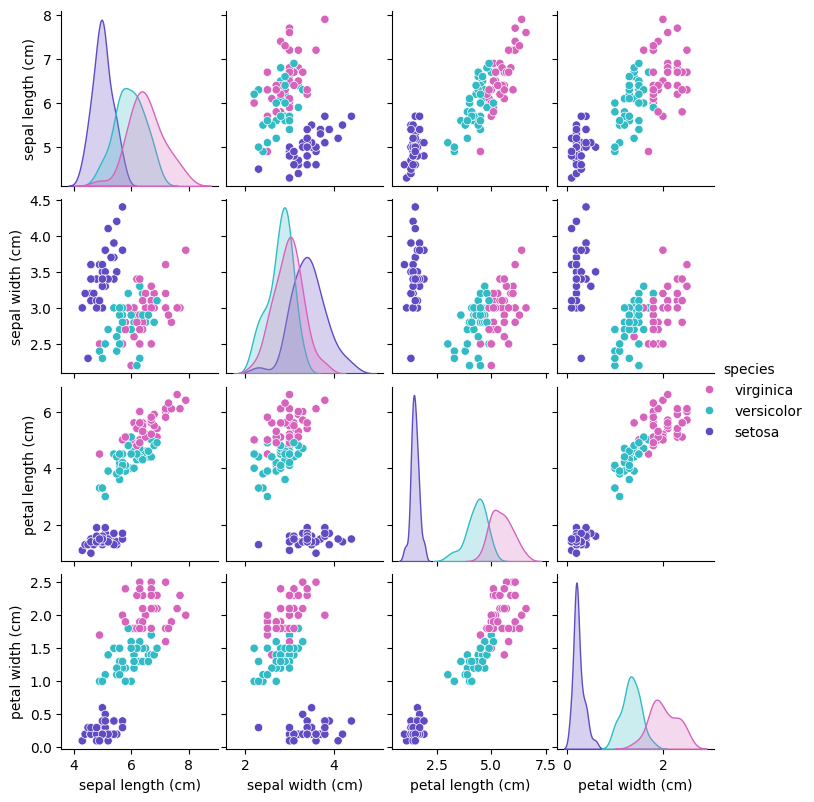

In [72]:
import seaborn as sns
import matplotlib.pyplot as plt

# Convertir a dataframe
iris_df = pd.DataFrame(X_train, columns=iris.feature_names)

# Añadir la clase "species" al DataFrame: ESTAS SON LAS ETIQUETAS DE LOS DATOS
iris_df["species"] = iris.target_names[y_train]

# Crear un pairplot
sns.pairplot(iris_df, hue="species", palette=sns.color_palette(["#D764BC", "#33BBC5", "#614BC3"]))
plt.gcf().set_size_inches(8,8)
plt.show()

Comprobamos si hay valores nulos:

In [73]:
iris_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120 entries, 0 to 119
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   sepal length (cm)  120 non-null    float64
 1   sepal width (cm)   120 non-null    float64
 2   petal length (cm)  120 non-null    float64
 3   petal width (cm)   120 non-null    float64
 4   species            120 non-null    object 
dtypes: float64(4), object(1)
memory usage: 4.8+ KB


Y comprobamos el rango, etc. de los valores de las variables numéricas (en este caso todas):

In [74]:
iris_df.describe()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
count,120.00000,120.000000,120.000000,120.000000
mean,5.82750,3.062500,3.750000,1.200000
std,0.79926,0.428219,1.731905,0.761467
min,4.30000,2.200000,1.000000,0.100000
25%,5.10000,2.800000,1.600000,0.300000
50%,5.80000,3.000000,4.400000,1.300000
75%,6.40000,3.300000,5.100000,1.800000
max,7.90000,4.400000,6.600000,2.500000


In [75]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)

Ahora podemos entrenar un árbol de decisión:

In [76]:
# Crear el árbol
model = DecisionTreeClassifier(random_state=0)

# Entrenar el modelo
model.fit(X_train_scaled, y_train)

DecisionTreeClassifier(random_state=0)

### 4.1 Explicabilidad del modelo
Una de las mayores ventajas de los árboles de decisión es que son modelos interpretables. Es decir, es sencillo dar una explicación de la predicción que se ha realizado. Podemos visualizar el árbol en formato texto usando:

In [77]:
from sklearn.tree import export_text
r = export_text(model, feature_names=iris.feature_names)
print(r)

|--- petal width (cm) <= -0.53
|   |--- class: 0
|--- petal width (cm) >  -0.53
|   |--- petal width (cm) <= 0.73
|   |   |--- petal length (cm) <= 0.93
|   |   |   |--- sepal length (cm) <= -1.10
|   |   |   |   |--- petal width (cm) <= 0.20
|   |   |   |   |   |--- class: 1
|   |   |   |   |--- petal width (cm) >  0.20
|   |   |   |   |   |--- class: 2
|   |   |   |--- sepal length (cm) >  -1.10
|   |   |   |   |--- sepal width (cm) <= -1.91
|   |   |   |   |   |--- petal length (cm) <= 0.58
|   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |--- petal length (cm) >  0.58
|   |   |   |   |   |   |--- class: 2
|   |   |   |   |--- sepal width (cm) >  -1.91
|   |   |   |   |   |--- class: 1
|   |   |--- petal length (cm) >  0.93
|   |   |   |--- class: 2
|   |--- petal width (cm) >  0.73
|   |   |--- petal length (cm) <= 0.64
|   |   |   |--- sepal length (cm) <= 0.15
|   |   |   |   |--- class: 1
|   |   |   |--- sepal length (cm) >  0.15
|   |   |   |   |--- class: 2
|   |   |

Y también podemos visualizar el árbol de decisión que hemos entrenado con el método plot_tree:

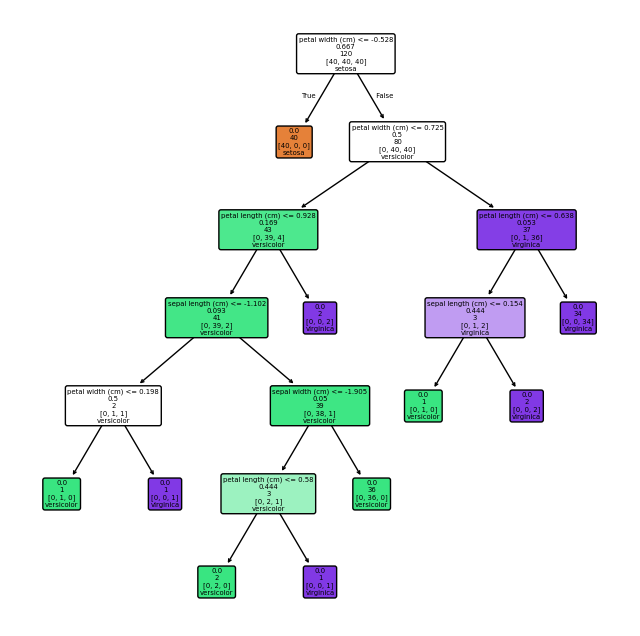

In [78]:
from sklearn.tree import plot_tree

plt.figure(figsize=(8,8))
plot_tree(model, feature_names=iris.feature_names, class_names=iris.target_names, filled=True, rounded=True, label="none")
plt.show()

El modelo que hemos almacenado en la variable modelo tiene un atributo llamado tree_ que almacena el objeto Tree entrenado, con toda la estructura del árbol:

In [79]:
model.tree_

Utilizando este objeto, podemos acceder a los atributos del árbol tales como:

node_count, el número total de nodos del árbol.
max_depth, la máxima profundidad del árbol.

In [80]:
print(f"Número de nodos del árbol: {model.tree_.node_count}")
print(f"Profundidad máxima del árbol: {model.tree_.max_depth}")

Número de nodos del árbol: 19
Profundidad máxima del árbol: 6


El método tree_.compute_node_depths() calcula la profundidad de cada nodo en el árbol.

In [81]:
model.tree_.compute_node_depths()

array([1, 2, 2, 3, 4, 5, 6, 6, 5, 6, 7, 7, 6, 4, 3, 4, 5, 5, 4])

Como ves, el método anterior devuelve un array para cada uno de los nodos. Este array representa cada nodo i del árbol binario, donde el nodo 0 es la raíz del árbol. Para cada nodo, el hijo izquierdo se encuentra en la posición
 y el hijo derecho se encuentra en la posición
.

Podemos utilizar tree_ para conocer estos índices:

children_left[i]: id del hijo izquierdo de i o -1 si i es un nodo hoja.
children_right[i]: id del hijo derecho de i o -1 si i es un nodo hoja.

In [82]:
print(f"Hijo izdo: {model.tree_.children_left}")
print(f"Hijo dcho: {model.tree_.children_right}")

Hijo izdo: [ 1 -1  3  4  5  6 -1 -1  9 10 -1 -1 -1 -1 15 16 -1 -1 -1]
Hijo dcho: [ 2 -1 14 13  8  7 -1 -1 12 11 -1 -1 -1 -1 18 17 -1 -1 -1]


Usando estos arrays tree_ también almacena otros atributos para cada nodo del árbol binario.

n_node_samples[i]: el número de objetos en el conjunto de entrenamiento que llegan al nodo i.

In [83]:
print(f"El número de objetos en cada nodo: {model.tree_.n_node_samples}")

El número de objetos en cada nodo: [120  40  80  43  41   2   1   1  39   3   2   1  36   2  37   3   1   2
  34]


### 4.2 Sobreajuste
Una desventaja de los árboles de decisión es que tienden al **sobreajuste**. El sobreajuste es un problema que se da cuando el rendimiento de un modelo es muy superior en los datos de entrenamiento respecto a los de test. Por ejemplo, si la accuracy del modelo en entrenamiento es de  0.960
 pero en test es de 0.800
 entonces está sufriendo un claro sobreajuste. Un ejemplo de sobreajuste:

In [84]:
# Crear el árbol
model = DecisionTreeClassifier(random_state=0)

# Entrenar el modelo
model.fit(X_train_scaled, y_train)

# Predecir las etiquetas de los datos de entrenamiento
y_train_pred = model.predict(X_train_scaled)

# Predecir las etiquetas de los datos de test
X_test_scaled = scaler.transform(X_test)
y_test_pred = model.predict(X_test_scaled)

# Obtener el accuracy
accuracy_train = accuracy_score(y_train, y_train_pred)
accuracy_test = accuracy_score(y_test, y_test_pred)

print(f"Accuracy en train: {accuracy_train:.3f}")
print(f"Accuracy en test: {accuracy_test:.3f}")

Accuracy en train: 1.000
Accuracy en test: 0.967


En este ejemplo se ve como todas las instancias de entrenamiento han sido correctamente clasificadas, pero no todas las de test. El sobreajuste en árboles de decisión se puede controlar mediante la poda del árbol:

Limitando la profundidad máxima. Esto es, el número de niveles del árbol, es decir, el número máximo de reglas de decisión que se pueden ejecutar antes de realizar la predicción.
El número de nodos hoja.
El número mínimo de instancias en un nodo.
El número mínimo de instancias en un nodo hoja.
Todas estas opciones se pueden configurar en el constructor de DecisionTreeClassifier. Por ejemplo, vamos a limitar que un nodo solo pueda ser un nodo hoja cuando haya al menos 5 instancias en él:

In [85]:
# Crear el árbol
model = DecisionTreeClassifier(random_state=0, min_samples_leaf=5)

# Entrenar el modelo
model.fit(X_train_scaled, y_train)

# Predecir las etiquetas de los datos de entrenamiento
y_train_pred = model.predict(X_train_scaled)

# Predecir las etiquetas de los datos de test
X_test_scaled = scaler.transform(X_test)
y_test_pred = model.predict(X_test_scaled)

# Obtener el accuracy
accuracy_train = accuracy_score(y_train, y_train_pred)
accuracy_test = accuracy_score(y_test, y_test_pred)

print(f"Accuracy en train: {accuracy_train:.3f}")
print(f"Accuracy en test: {accuracy_test:.3f}")

Accuracy en train: 0.967
Accuracy en test: 1.000


In [86]:
r = export_text(model, feature_names=iris.feature_names)
print(r)

|--- petal width (cm) <= -0.53
|   |--- class: 0
|--- petal width (cm) >  -0.53
|   |--- petal width (cm) <= 0.73
|   |   |--- petal length (cm) <= 0.70
|   |   |   |--- sepal length (cm) <= -0.66
|   |   |   |   |--- class: 1
|   |   |   |--- sepal length (cm) >  -0.66
|   |   |   |   |--- class: 1
|   |   |--- petal length (cm) >  0.70
|   |   |   |--- class: 2
|   |--- petal width (cm) >  0.73
|   |   |--- petal length (cm) <= 0.70
|   |   |   |--- class: 2
|   |   |--- petal length (cm) >  0.70
|   |   |   |--- class: 2



Este tipo de opciones de los modelos pretenden mejorar la generalización del modelo: que el rendimiento en datos desconocidos sea lo más parecido al de test. En general se basan en restringir el modelo para que no se adapta excesivamente a los datos de entrenamiento y así aprenda patrones más generales. No obstante, tenemos que tener cuidado: si restringimos demasiado el modelo para mejorar su generalización puede llegar un punto donde el modelo pierda capacidad de aprendizaje.

Por ejemplo, si limitamos la profundidad máxima del árbol a 1, el modelo no podrá aprender patrones complejos y su rendimiento será muy bajo:

In [87]:
# Crear el árbol
model = DecisionTreeClassifier(random_state=0, max_depth=1)

# Entrenar el modelo
model.fit(X_train_scaled, y_train)

# Predecir las etiquetas de los datos de entrenamiento
y_train_pred = model.predict(X_train_scaled)

# Predecir las etiquetas de los datos de test
X_test_scaled = scaler.transform(X_test)
y_test_pred = model.predict(X_test_scaled)

# Obtener el accuracy
accuracy_train = accuracy_score(y_train, y_train_pred)
accuracy_test = accuracy_score(y_test, y_test_pred)

print(f"Accuracy en train: {accuracy_train:.3f}")
print(f"Accuracy en test: {accuracy_test:.3f}")

Accuracy en train: 0.667
Accuracy en test: 0.667


El rendimiento en entrenamiento y test es el mismo, pero el árbol solo puede aprender una regla, lo cual no es suficiente para clasificar correctamente una gran cantidad de instancias.

In [88]:
r = export_text(model, feature_names=iris.feature_names)
print(r)

|--- petal width (cm) <= -0.53
|   |--- class: 0
|--- petal width (cm) >  -0.53
|   |--- class: 1



### 4.3 Optimización de hiperparámetros
Al igual que ocurría con KNN, escoger los valores de estos hiperparámetros no es directo. En general debemos tener en cuenta un balance entre sobreajuste y generalización, y usualmente realizaremos una búsqueda de hiperparámetros para encontrar la mejor combinación (al igual que hacíamos en KNN).

Vamos a probar los siguientes valores de hiperparámetros:

In [89]:
param_grid = {
    "classifier__max_depth": [1, 2, 3, None], # Cuando es None, no se restringe la profundidad (puede ser cualquiera)
    "classifier__min_samples_split": [5, 10],  # Número mínimo de muestras requeridas para poder dividir un nodo interno
    "classifier__min_samples_leaf": [5, 10,],  # Número mínimo de muestras requeridas para ser una hoja
    "classifier__criterion": ["gini", "entropy"],  # Criterio para la división
    "classifier__max_leaf_nodes": [3, 5, 10, None]  # Restringir el número máximo de nodos hoja
}

# Número de combinaciones posibles
combinaciones = 1
for key, value in param_grid.items():
    combinaciones *= len(value)
print(f"Número de combinaciones posibles: {combinaciones}")

Número de combinaciones posibles: 128


DecisionTreeClassifier tiene muchos más hiperparámetros que KNeighborsClassifier, por lo que el número de combinaciones posibles es mucho mayor. En este caso, el número de combinaciones posibles es 128
. Esto quiere decir que si realizamos un grid search con estos hiperparámetros y 10
-fold CV, se entrenarán 1280
 modelos en total. Por ello, es importante tener en cuenta la complejidad de la búsqueda de hiperparámetros.

Como hacíamos con KNN, vamos a crear un pipeline para el escalado y el modelo, y vamos a realizar la búsqueda de hiperparámetros:

In [90]:
# Crear el pipeline
pipeline = Pipeline(steps=[("scaler", StandardScaler()), ("classifier", DecisionTreeClassifier(random_state=0))])
display(pipeline)

# Configurar CV y grid search
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=0)
grid_search = GridSearchCV(pipeline, param_grid, cv=cv, scoring="accuracy")

grid_search.fit(X_train, y_train) # Sobre los datos sin escalar porque ahora esto lo realiza el pipeline

# Mostrar los resultados para cada combinación de hiperparámetros

keys_to_keep = ["mean_test_score", "std_test_score", "rank_test_score"]
keys_to_keep += [key for key in grid_search.cv_results_ if key.startswith("param_")]
filtered_results = {key: grid_search.cv_results_[key] for key in keys_to_keep}
cleaned_results = {
    key.replace("param_classifier__", "") if key.startswith("param_classifier__") else key: value
    for key, value in filtered_results.items()
}

results = pd.DataFrame(cleaned_results)

display(results.sort_values(by="rank_test_score").head(10))

Pipeline(steps=[('scaler', StandardScaler()),
                ('classifier', DecisionTreeClassifier(random_state=0))])

,mean_test_score,std_test_score,rank_test_score,criterion,max_depth,max_leaf_nodes,min_samples_leaf,min_samples_split
63,0.933333,0.062361,1,gini,None,None,10,10
97,0.933333,0.062361,1,entropy,3,3,5,10
96,0.933333,0.062361,1,entropy,3,3,5,5
95,0.933333,0.062361,1,entropy,2,None,10,10
94,0.933333,0.062361,1,entropy,2,None,10,5
93,0.933333,0.062361,1,entropy,2,None,5,10
92,0.933333,0.062361,1,entropy,2,None,5,5
91,0.933333,0.062361,1,entropy,2,10,10,10
90,0.933333,0.062361,1,entropy,2,10,10,5
89,0.933333,0.062361,1,entropy,2,10,5,10


En este caso, el dataset es sencillo y tiene pocos datos, por lo que hay muchos modelos empatados.



In [91]:
# Obtener el modelo con los mejores hiperparámetros. Ya está entrenado: GridSearchCV se ha encargado de ello porque usamos el valor por defecto refit=True
best_model = grid_search.best_estimator_

best_params = {key.replace("classifier__", ""): value for key, value in grid_search.best_params_.items()}
print("Mejores hiperparámetros:")
display(best_params)

# Predecir las etiquetas de los datos de test
y_pred = best_model.predict(X_test)

# Obtener el accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy final del modelo: {accuracy:.3f}")

Mejores hiperparámetros:


{'criterion': 'gini',
 'max_depth': 2,
 'max_leaf_nodes': 3,
 'min_samples_leaf': 5,
 'min_samples_split': 5}

Accuracy final del modelo: 0.967


El mejor árbol es:

In [92]:
r = export_text(best_model.named_steps["classifier"], feature_names=iris.feature_names)
print(r)

|--- petal width (cm) <= -0.53
|   |--- class: 0
|--- petal width (cm) >  -0.53
|   |--- petal width (cm) <= 0.73
|   |   |--- class: 1
|   |--- petal width (cm) >  0.73
|   |   |--- class: 2



**EJERCICIO FINAL: optimización de hiperparámetros y comparación de modelos (10 + 10 minutos)**

Siguiendo con el dataset MathLearningDataset.csv, aplica el preprocesamiento que diseñamos anteriormente y optimiza los dos modelos que hemos visto, comparándolos finalmente en el conjunto de test:

Realiza una optimización de hiperparámetros del modelo
-NN. Utiliza 5-fold CV con el conjunto de entrenamiento.
Realiza una optimización de hiperparámetros del modelo árbol de decisión. Utiliza 5-fold CV con el conjunto de entrenamiento.
Compara en el conjunto de test los resultados del mejor modelo de ambos tipos.

**Paso 1: Cargar y preprocesar los datos**

In [115]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

# Cargar el dataset
data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/datasets/MathLearningDataset.csv')

# Separar las variables (X) de las etiquetas (y)
X = data.drop('Type of Answer', axis=1)
y = data['Type of Answer']

# Dividir las características en numéricas y categóricas
numeric_features = ['Student Age', 'Response Time (s)']
categorical_features = ['Student Country', 'Question Level', 'Topic', 'Subtopic']

# Crear transformadores para cada tipo de característica
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

# Combinar los transformadores usando ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Dividir los datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

**Paso 2: Optimización de hiperparámetros del modelo k-NN:**

In [135]:
# Definir el pipeline para k-NN
knn_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', KNeighborsClassifier())
])

# Definir la rejilla de hiperparámetros para k-NN
knn_param_grid = {
    'classifier__n_neighbors':range(1, 21),  # Lista de valores enteros positivos
    'classifier__metric': ['euclidean', 'manhattan']
}

# Realizar la búsqueda de hiperparámetros con GridSearchCV
knn_grid_search = GridSearchCV(knn_pipeline, knn_param_grid, cv= 5, scoring='accuracy')
knn_grid_search.fit(X_train, y_train)

# Mostrar los mejores hiperparámetros y la mejor puntuación
print("Mejores hiperparámetros para k-NN:", knn_grid_search.best_params_)
print("Mejor puntuación para k-NN:", knn_grid_search.best_score_)

# Obtener el mejor modelo k-NN
best_knn_model = knn_grid_search.best_estimator_

Mejores hiperparámetros para k-NN: {'classifier__metric': 'manhattan', 'classifier__n_neighbors': 19}
Mejor puntuación para k-NN: 0.6035847759525745


**Paso 3: Optimizar el modelo de árbol de decisión**



In [136]:
# Definir el pipeline para el árbol de decisión
tree_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', DecisionTreeClassifier())
])

# Definir la rejilla de hiperparámetros para el árbol de decisión
tree_param_grid = {
    #'classifier__max_depth': [None, 5, 10, 15],  # Probar diferentes profundidades máximas
    #'classifier__min_samples_split': [2, 6, 7],  # Probar diferentes valores para la división mínima de muestras
    #'classifier__criterion': ['gini', 'entropy'],
    'classifier__max_depth': range(1, 21),  # Profundidad máxima de 1 a 20
    'classifier__criterion': ['gini', 'entropy'],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4]
}

# Realizar la búsqueda de hiperparámetros con GridSearchCV
tree_grid_search = GridSearchCV(tree_pipeline, tree_param_grid, cv=5, scoring='accuracy')
tree_grid_search.fit(X_train, y_train)

# Mostrar los mejores hiperparámetros y la mejor puntuación
print("Mejores hiperparámetros para árbol de decisión:", tree_grid_search.best_params_)
print("Mejor puntuación para árbol de decisión:", tree_grid_search.best_score_)

# Obtener el mejor modelo de árbol de decisión
best_tree_model = tree_grid_search.best_estimator_

Mejores hiperparámetros para árbol de decisión: {'classifier__criterion': 'gini', 'classifier__max_depth': 11, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 10}
Mejor puntuación para árbol de decisión: 0.5972998247941932


**Paso 4: Comparar los modelos en el conjunto de test**

In [137]:
# Evaluar el mejor modelo k-NN en el conjunto de test
knn_predictions = best_knn_model.predict(X_test)
knn_accuracy = accuracy_score(y_test, knn_predictions)
print("Accuracy para k-NN en el conjunto de test:", knn_accuracy)

# Evaluar el mejor modelo de árbol de decisión en el conjunto de test
tree_predictions = best_tree_model.predict(X_test)
tree_accuracy = accuracy_score(y_test, tree_predictions)
print("Accuracy para árbol de decisión en el conjunto de test:", tree_accuracy)

Accuracy para k-NN en el conjunto de test: 0.5926701570680628
Accuracy para árbol de decisión en el conjunto de test: 0.5931937172774869
